In [337]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.datasets import make_classification
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from collections import defaultdict

import sklearn.datasets

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline
print(torch.__version__) 

1.6.0


In [463]:
n_classes = 10

X, y = sklearn.datasets.make_classification(n_samples=1000,
                                            n_features=10,
                                            n_informative=5,
                                            n_redundant=2,
                                            n_repeated=0,
                                            class_sep=1.0,
                                            n_classes=n_classes)

n_features = X.shape[1]

In [464]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=7)
print('len train:', len(X_train))
print('len test:', len(X_test))

len train: 800
len test: 200


In [465]:
BATCH_SIZE = 32

training_dataset = TensorDataset(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).long())
train_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

testing_dataset = TensorDataset(torch.from_numpy(X_test).float(), 
                                torch.from_numpy(y_test).long())
test_loader = DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [466]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_hidden=128):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
            nn.Linear(n_hidden, n_classes),
            nn.LogSoftmax()
        )

    def forward(self, x):
        return self.network(x)

In [467]:
def grad_immediate_sensitivity(model, criterion, inputs, labels, epoch):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
#     print('outputs', outputs)
#     print('labels', labels)
    loss = criterion(torch.squeeze(outputs), labels)
#     print(loss)
    
    # (1) first-order gradient (wrt parameters)
    first_order_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    
    # (2) L2 norm of the gradient from (1)
    grad_l2_norm = torch.norm(torch.cat([x.view(-1) for x in first_order_grads]), p = 2)
    
    # (3) Gradient (wrt inputs) of the L2 norm of the gradient from (2)
    sensitivity_vec = torch.autograd.grad(grad_l2_norm, inp, retain_graph=True)[0]
    
    # (4) L2 norm of (3) - "immediate sensitivity"
    s = [torch.norm(v, p=2).numpy().item() for v in sensitivity_vec]

    loss.backward()
    return loss, s

In [468]:
def gaussian_pdf(sd, x):
    if sd <= 0:
        raise ValueError('standard deviation must be positive but is {}'.format(sd))
    else: #sd > 0
        return np.e ** (-0.5*(x/sd)**2) / sd


def membership_inf(model, avg_train_loss, inputs, labels):
    inp = Variable(inputs, requires_grad=True)
    
    outputs = model.forward(inp)
    loss = nn.NLLLoss(reduction='none')(torch.squeeze(outputs), labels)
    pass_inf = [1 if abs(l) < avg_train_loss else 0 for l in loss]
    
    return pass_inf, [float(l) for l in loss]

In [469]:
def run_membership_inference_attack(model, avg_train_l, X_target, y_target):
    _, sensitivities = grad_immediate_sensitivity(model, 
                                                      nn.NLLLoss(), 
                                                      torch.from_numpy(X_target).float(), 
                                                      torch.from_numpy(y_target).long(), 
                                                      None)
    max_sen = max(sensitivities)
    norm_sen = [s/max_sen for s in sensitivities]
    min_exp = min([np.log(s) for s in sensitivities if s != 0])
    log_sen = [np.log(s) if s !=0 else min_exp - 1 for s in sensitivities]
    paws = [s - (min_exp - 1) for s in log_sen]

    pass_inf, train_loss = membership_inf(model, 
                                          avg_train_l, 
                                          torch.from_numpy(X_target).float(), 
                                          torch.from_numpy(y_target).long())
    #plt.scatter(paws, pass_inf)
    #print('positive ratio:',sum(pass_inf)/len(pass_inf))
    return sum(pass_inf)/len(pass_inf)

In [470]:
def run_experiment(epsilon, epochs, add_noise=False, throw_out_threshold=False):
    # reset the model
    model = Classifier(n_features=n_features)
    model_criterion = nn.NLLLoss() 
    model_optimizer = optim.Adam(model.parameters(),lr=0.001)
    alpha = 25
    epsilon_iter = epsilon / epochs

    info = defaultdict(lambda: [])
    train_accs = []
    test_accs = []
    advs = []
    
    local_X_train = torch.from_numpy(X_train).float()
    local_X_test = torch.from_numpy(X_test).float()
    local_y_train = torch.from_numpy(y_train).long()
    local_y_test = torch.from_numpy(y_test).long()
    
    for epoch in range(epochs):
        for x_batch_train, y_batch_train in train_loader:
            plz_update = True

            model_optimizer.zero_grad()
            loss, batch_sensitivities = grad_immediate_sensitivity(model, model_criterion, x_batch_train, y_batch_train,epoch)
            batch_sensitivity = np.max(batch_sensitivities) / BATCH_SIZE

            if throw_out_threshold:
                # delete gradients?
                with torch.no_grad():
                    for p in model.parameters():
                        p.grad = None

                # throw out "bad" examples
                good_idxs = np.array(batch_sensitivities) < throw_out_threshold
                #print(len(x_batch_train[good_idxs]), 'out of', len(x_batch_train))

                # re-do the gradients
                good_xs = x_batch_train[good_idxs]
                good_ys = y_batch_train[good_idxs]
                
                if len(good_xs) / len(x_batch_train) < 0.5:
                    plz_update = False
                else:
                    outputs = model.forward(good_xs)
                    loss = model_criterion(torch.squeeze(outputs), good_ys)

                    loss.backward()
                
                batch_sensitivity = min(throw_out_threshold, batch_sensitivity)

            sigma = np.sqrt((batch_sensitivity**2 * alpha) / (2 * epsilon_iter))

            if add_noise:
                with torch.no_grad():
                    for p in model.parameters():
                        p.grad += (sigma * torch.randn(1).float())

            if plz_update:
                model_optimizer.step()

        lossfn = model_criterion
        avg_train_l = lossfn(torch.squeeze(model.forward(local_X_train)), local_y_train)
        avg_test_l = lossfn(torch.squeeze(model.forward(local_X_test)), local_y_test)
        
        tpr = run_membership_inference_attack(model, avg_train_l, X_train, y_train)
        fpr = run_membership_inference_attack(model, avg_train_l, X_test, y_test)
        adv = tpr-fpr

        info['train_l'].append(avg_train_l.item())
        info['test_l'].append(avg_test_l.item())
        info['adv'].append(adv)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}: train loss {avg_train_l}, test loss {avg_test_l}, adv {adv}')

    return info, model

In [530]:
info, model = run_experiment(1.0, 100, add_noise=False, throw_out_threshold=.07)

Epoch 0: train loss 2.007674217224121, test loss 2.076185941696167, adv 0.057499999999999996
Epoch 10: train loss 1.119553565979004, test loss 1.43924880027771, adv 0.09750000000000003
Epoch 20: train loss 1.1954240798950195, test loss 1.6532363891601562, adv 0.17374999999999996
Epoch 30: train loss 1.483048677444458, test loss 2.1260085105895996, adv 0.11875000000000002
Epoch 40: train loss 1.4242390394210815, test loss 2.269075393676758, adv 0.15375000000000005
Epoch 50: train loss 1.49662184715271, test loss 2.547992467880249, adv 0.20124999999999993
Epoch 60: train loss 1.4688019752502441, test loss 2.5831894874572754, adv 0.19499999999999995
Epoch 70: train loss 1.8942371606826782, test loss 3.2112557888031006, adv 0.18625000000000003
Epoch 80: train loss 1.718456745147705, test loss 3.1498889923095703, adv 0.18875000000000008
Epoch 90: train loss 1.7446739673614502, test loss 3.2162744998931885, adv 0.21875


In [531]:
def accuracy(model, X, y):
    Xt = torch.from_numpy(X).float()
    yt = torch.from_numpy(y).long()
    outputs = model(Xt)
    values, indices = outputs.max(dim=1)
    y_hat = indices.detach().numpy()
    accuracy = np.sum(y_hat == y) / len(y)
    return accuracy

accuracy(model, X_test, y_test)

0.435

In [532]:
lossfn = nn.NLLLoss()

avg_train_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_train).float())),
                    torch.from_numpy(y_train).long())

avg_test_l = lossfn(torch.squeeze(model.forward(torch.from_numpy(X_test).float())),
                    torch.from_numpy(y_test).long())

print('average train loss:', avg_train_l)
print('average test loss:', avg_test_l)

average train loss: tensor(2.1026, grad_fn=<NllLossBackward>)
average test loss: tensor(3.9880, grad_fn=<NllLossBackward>)


In [533]:
tpr = run_membership_inference_attack(model, avg_train_l, X_train, y_train)
fpr = run_membership_inference_attack(model, avg_train_l, X_test, y_test)
print('Adv:', tpr - fpr)

Adv: 0.2037500000000001


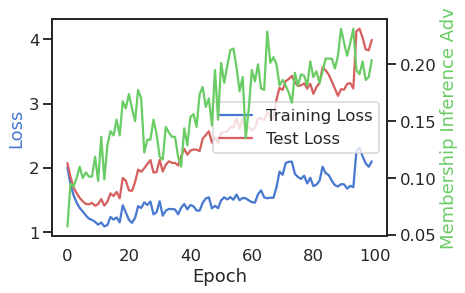

In [534]:
plt.figure()

ax1 = plt.gca()
ax1.plot(info['train_l'], color='b', label='Training Loss')
ax1.plot(info['test_l'], color='r', label='Test Loss')
ax1.legend(loc='center right')
ax1.set_ylabel('Loss', color='b')

ax2 = ax1.twinx()
ax2.plot(info['adv'], color='g')
ax2.set_ylabel('Membership Inference Adv', color='g')

#fig.tight_layout()
ax1.set_xlabel('Epoch')
plt.show() 